## Logistic Regression Demonstration
We will implement logistic regression and demonstrate how the outputs can be interpreted as probabilities. We will also explore essential performance metrics and use optimised approach using `sklearn` on the Titanic dataset.

In [1]:
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
import warnings; warnings.filterwarnings('ignore')

We’ll use a cleaned Titanic dataset with selected features such as demographics (`Sex`, `Age`, `Family_size`, `Title_*)`, socio-economic details (`Pclass_1`, `Pclass_2`, `Pclass_3`, `Fare`) and embarking details (`Emb_1`, `Emb_2`, `Emb_3`)

The target feature is `Survived` (1 = survived, 0 = did not survive)

In [2]:
data_path = '../data/raw/'
df = pd.read_csv(data_path + 'titanic.csv')

X = df.drop(['PassengerId', 'Survived'], axis = 1)
y = df['Survived']

print(f'Input shape: {X.shape}')
print(f'Survival rate: {y.mean():.1%}')

Input shape: (891, 15)
Survival rate: 38.4%


The dataset is somewhat imbalanced. The `train_test_split()` function splits arrays or matrices into random train and test subsets. We will **stratify** on the target feature, that is, we will keep the proportion of positive class roughly the same in test and training sets.

W**hat stratify=y does**
- When you split data into train/test sets, you usually want the class distribution (the ratio of positives vs negatives) to be the same in both sets.
- By default, train_test_split just splits randomly.
- If your dataset is imbalanced (say 90% healthy, 10% sick), random splitting might give you:
    - Train: 95% healthy, 5% sick
    - Test: 85% healthy, 15% sick
    - → That mismatch can confuse training & evaluation.

✅ Setting stratify=y ensures the split preserves the same proportion of classes as in the full dataset.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
print(f'Train: {X_train.shape[0]}, Test: {X_test.shape[0]}')
print(f'Train survival rate: {y_train.mean():.1%}, Test survival rate: {y_test.mean():.1%}')

Train: 712, Test: 179
Train survival rate: 38.3%, Test survival rate: 38.5%


Let's train the model using `sklearn.LogisticRegression`. You can try out different number of iterations. Unlike our previous arbitrary parameters approach, `sklearn` uses an optimisation algorithm to minimise log loss efficiently.

In [5]:
model = LogisticRegression(random_state = 0)
model.fit(X_train, y_train)
print(f'Intercept (bias): {model.intercept_[0]:.3f}')
print(f'Coefficients: {len(model.coef_[0])} features')

Intercept (bias): 1.658
Coefficients: 15 features


A point to note here is that `sklearn` offers several solvers for logistic regression. Some use gradient descent whereas others use higher order gradients or matrices (default is `lbfgs`). These are beyond the scope of this discussion. 

Model outputs probabilities through sigmoid, then converts to binary predictions.

Let's see the probabilities and class predictions

`predict_proba` returns the predicted probability for each class.

- Shape = (n_samples, n_classes)
- Column 0 = probability of class 0 (e.g., "Die")
- Column 1 = probability of class 1 (e.g., "Survive")
- Example row: [0.25, 0.75] → model thinks 25% chance die, 75% chance survive

`predict` gives the final class prediction (0 or 1).
- It applies the default threshold 0.5 to predict_proba.
- Example: if probabilities = [0.25, 0.75], then predict = 1 (Survive)

`results_df` Shows side-by-side:
- Actual: the true class from the test set.
- Prob_Die: model’s predicted probability of class 0.
- Prob_Survive: model’s predicted probability of class 1.
- Prediction: the final predicted label (0 or 1).

In [6]:
y_proba = model.predict_proba(X_test)  # Probabilities
y_pred = model.predict(X_test)  # Predictions
results_df = pd.DataFrame({'Actual': y_test.iloc[:5].values,'Prob_Die': y_proba[:5, 0],'Prob_Survive': y_proba[:5, 1],'Prediction': y_pred[:5]})
print(results_df.round(3))

   Actual  Prob_Die  Prob_Survive  Prediction
0       0     0.956         0.044           0
1       0     0.930         0.070           0
2       0     0.680         0.320           0
3       0     0.932         0.068           0
4       1     0.051         0.949           1


Let's first check the log loss on both training and testing sets

In [7]:
test_log_loss = log_loss(y_test, y_proba)
print(f'Log Loss (Test): {test_log_loss:.3f}')

y_proba_train = model.predict_proba(X_train) 
y_pred_train = model.predict(X_train)  
train_log_loss = log_loss(y_train, y_proba_train)
print(f'Log Loss (Train): {train_log_loss:.3f}')

Log Loss (Test): 0.455
Log Loss (Train): 0.410


A lower log loss indicates better performance. The test loss being slightly higher than the train loss suggests the model generalises well without overfitting.

### Evaluation
Let's compare the confusion matrices for training and testing and see how classification and misclassification counts look like for both

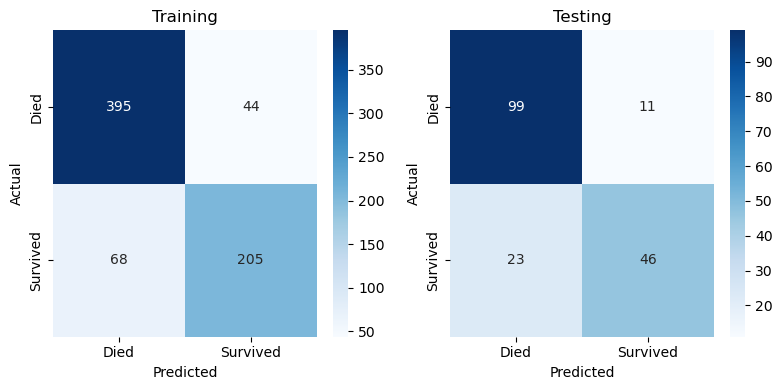

In [8]:
cm_train = confusion_matrix(y_train, y_pred_train)  # Train confusion matrix
cm_test = confusion_matrix(y_test, y_pred)  # Test confusion matrix
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
sns.heatmap(cm_train, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Died', 'Survived'], yticklabels = ['Died', 'Survived'], ax = axes[0]); axes[0].set_title('Training'); axes[0].set_ylabel('Actual'); axes[0].set_xlabel('Predicted')
sns.heatmap(cm_test, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Died', 'Survived'], yticklabels = ['Died', 'Survived'], ax = axes[1]); axes[1].set_title('Testing'); axes[1].set_ylabel('Actual'); axes[1].set_xlabel('Predicted'); plt.tight_layout();

We can see that these are mostly proportionate between train and test sets, which suggests low possibility of overfitting. Let's look at the other metrics as well.

In [9]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label = 1)  # pos_label = 1 indicates positive class is "1"
f1 = f1_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label = 0)  # pos_label = 0 indicates positive class is "0"

print(f'Accuracy:    {accuracy:.3f}')
print(f'Precision:   {precision:.3f}  (of predicted survivors, how many actually survived)')
print(f'Recall:      {recall:.3f}  (of actual survivors, how many we caught)')
print(f'Specificity: {specificity:.3f}  (of actual deaths, how many we caught)')
print(f'F1-Score:    {f1:.3f}')

Accuracy:    0.810
Precision:   0.807  (of predicted survivors, how many actually survived)
Recall:      0.667  (of actual survivors, how many we caught)
Specificity: 0.900  (of actual deaths, how many we caught)
F1-Score:    0.730


We can also print an overall classification report for the model

In [9]:
print(classification_report(y_test, y_pred, target_names = ['Died', 'Survived']))

              precision    recall  f1-score   support

        Died       0.81      0.90      0.85       110
    Survived       0.81      0.67      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179



To see the effect of changing the threshold on the predictions, let's define a function which assigns labels according to provided threshold

In [10]:
y_proba = model.predict_proba(X_test)[:, 1] # Outputs [p(class0), p(class1)]
def predict(y_proba, threshold): return (y_proba >= threshold).astype(int)

In [11]:
y_pred_low = predict(y_proba, 0.3)  # Cutoff of 0.3
print(classification_report(y_test, y_pred_low, target_names = ['Died', 'Survived']))

              precision    recall  f1-score   support

        Died       0.87      0.72      0.79       110
    Survived       0.65      0.83      0.73        69

    accuracy                           0.76       179
   macro avg       0.76      0.77      0.76       179
weighted avg       0.78      0.76      0.76       179



In [12]:
y_pred_low = predict(y_proba, 0.9)  # Cutoff of 0.9
print(classification_report(y_test, y_pred_low, target_names = ['Died', 'Survived']))

              precision    recall  f1-score   support

        Died       0.69      0.99      0.81       110
    Survived       0.95      0.28      0.43        69

    accuracy                           0.72       179
   macro avg       0.82      0.63      0.62       179
weighted avg       0.79      0.72      0.66       179



The evaluation metrics change with threshold. Let's plot a precision recall curve for different values of threshold.

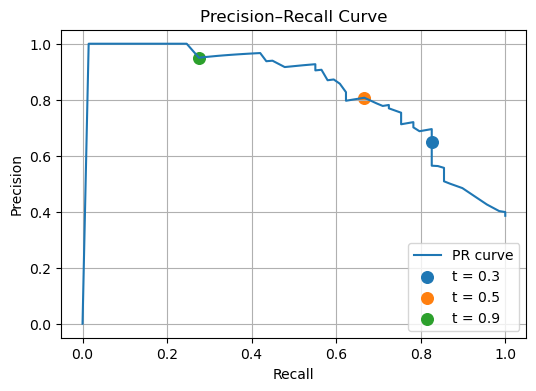

In [13]:
prec, rec, ths = [], [], np.linspace(0, 1, 101)

for t in ths:
    y_pred = predict(y_proba, t)
    prec.append(precision_score(y_test, y_pred, zero_division = 0))
    rec.append(recall_score(y_test, y_pred))

plt.figure(figsize = (6, 4))
    
plt.plot(rec, prec, label = 'PR curve')

for t in [0.3, 0.5, 0.9]:
    idx = np.argmin(np.abs(ths - t))
    plt.scatter(rec[idx], prec[idx], s = 70, label = f't = {t}')
    
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall Curve'); plt.legend(); plt.grid(True)

Similarly, the ROC curve

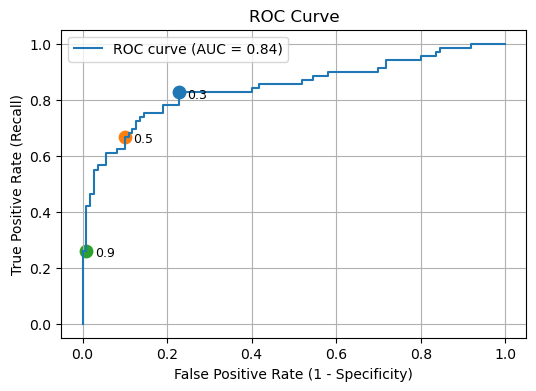

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)  # Compute ROC curve values
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = f'ROC curve (AUC = {roc_auc:.2f})')

# Find closest threshold index
for t in [0.3, 0.5, 0.9]:
    idx = (np.abs(thresholds - t)).argmin()
    plt.scatter(fpr[idx], tpr[idx], s = 80, marker = 'o')
    plt.text(fpr[idx] + 0.02, tpr[idx] - 0.02, f'{t}', fontsize = 9)

plt.xlabel('False Positive Rate (1 - Specificity)'); plt.ylabel('True Positive Rate (Recall)'); plt.title('ROC Curve'); plt.legend(); plt.grid(True)

Let's see the impact of positive class choice on performance metrics

In [15]:
print('Survived as Positive Class')
print(f'Precision:\t{precision:.3f} (predicted survivors who actually survived)\nRecall:\t\t{recall:.3f} (actual survivors we identified)')

precision_died = precision_score(y_test, y_pred, pos_label=0)  # Flip to 'died' as positive class
recall_died = recall_score(y_test, y_pred, pos_label=0)

print('\nDied as Positive Class')
print(f'Precision:\t{precision_died:.3f} (predicted deaths who actually died)\nRecall:\t\t{recall_died:.3f} (actual deaths we identified)')

Survived as Positive Class
Precision:	0.807 (predicted survivors who actually survived)
Recall:		0.667 (actual survivors we identified)

Died as Positive Class
Precision:	0.615 (predicted deaths who actually died)
Recall:		1.000 (actual deaths we identified)


This is only a preliminary analysis. You are encouraged to explore the documentations further.